# Finding Heavy Traffic Indicators on I-94 Highway

In this project, we clean and analyse a dataset of westbound traffic on the I-94 highway. We seek to understand what are the indicators/possible causes of heavy traffic on it. We do this by comparing the aggregates of columns such as 'traffic_volume' with possible indicators such as 'rain_1h' etc. The data dictionary is as follows:

|Header|Description|
|------|-----------|
|holiday|Categorical US National holidays plus regional holiday, Minnesota State Fair|
|temp|Numeric Average temp in kelvin|
|rain_1h|Numeric Amount in mm of rain that occurred in the hour|
|snow_1h|Numeric Amount in mm of snow that occurred in the hour|
|clouds_all|Numeric Percentage of cloud cover|
|weather_main|Categorical Short textual description of the current weather|
|weather_description|Categorical Longer textual description of the current weather|
|date_time|DateTime Hour of the data collected in local CST time|
|traffic_volume|Numeric Hourly I-94 ATR 301 reported westbound traffic volume|

The dataset was prepared by John Hogue, and was uploaded to the UCI Machine Learning Repository on 7 July 2019. The data spans over the years of 2012 - 2018.



In [1]:
# importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# reading in the dataset file (.csv)

traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
print(traffic.head())
print(traffic.tail())
print(traffic.info())

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  
      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0   

## Initial Observations from Dataset

<ul>
    <li> The values of the 'date_time' column are in the YYYY-MM-DD HH:MM:SS format. </li>
    <li> There are no missing values since the non-null count for all columns match the number of entries. </li>

</ul>

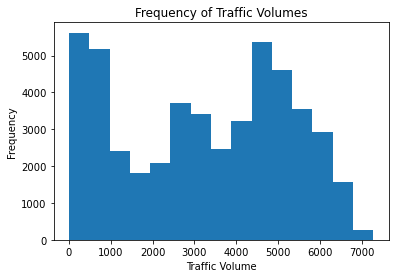

In [57]:
# Plotting a histogram of the 'traffic_volume' column

traffic['traffic_volume'].plot.hist(bins=15)
plt.xlabel('Traffic Volume')
plt.title('Frequency of Traffic Volumes')
plt.show()

In [4]:
# Checking the statistics of the 'traffic_volume' column

traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

It is noted that the histogram's shape is double-peaked. We will attempt to understand why there are two highly different peaks in hourly traffic volume.

From the above histogram, we note that the traffic volume rarely rises above about 5300 cars per hour. This is corroborated by the fact that the 75th percentile of traffic volume is 4933, which indicates that the traffic volume only exceeds this amount about 25% of the time.

Given that the 25th percentile of the traffic volume is 1193 cars/hour (i.e. 25% of the time traffic volume is less than or equal to 1193 cars/hour), it seems that there are distinct but equally large periods where the traffic volume quadruples from ~1193 to ~4933.

The mean hourly traffic is 3259 cars/hour, and the maximum was 7280 cars/hour.
The most common hourly traffic volumes fall in the ranges 0-1000 and 4500-5300. 


We first begin by checking if there is a correlation between the time (day/night) and the hourly traffic volume.

In [5]:
# We first convert our 'date_time' column dtype to datetime.

traffic['date_time'] = pd.to_datetime(traffic['date_time'])
traffic['date_time'].dtype


dtype('<M8[ns]')

We define day to be between the hours of 0700Hrs to 1900Hrs, and night to be from 1900Hrs to 0700Hrs.
We hence isolate the daytime and nighttime data and prepare seperate dataframes for both.

In [6]:
type(traffic['date_time'].dt.hour)

pandas.core.series.Series

In [25]:
# Isolating daytime (0700Hrs inclusive - 1900Hrs) data

daytime_bool = (traffic['date_time'].dt.hour >= 7) & (traffic['date_time'].dt.hour < 19)
traffic_day = traffic.loc[daytime_bool, :]
print(traffic_day['date_time'].dt.hour.unique())
print(traffic_day.info())
print(traffic_day.describe())

[ 9 10 11 12 13 14 15 16 17 18  8  7]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23877 entries, 0 to 48198
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              23877 non-null  object        
 1   temp                 23877 non-null  float64       
 2   rain_1h              23877 non-null  float64       
 3   snow_1h              23877 non-null  float64       
 4   clouds_all           23877 non-null  int64         
 5   weather_main         23877 non-null  object        
 6   weather_description  23877 non-null  object        
 7   date_time            23877 non-null  datetime64[ns]
 8   traffic_volume       23877 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 1.8+ MB
None
               temp      rain_1h       snow_1h    clouds_all  traffic_volume
count  23877.000000  23877.00000  23877.000000  23877.000000    

In [26]:
# Isolating daytime (1900Hrs inclusive - 0700Hrs) data

nighttime_bool = (traffic['date_time'].dt.hour < 7) | (traffic['date_time'].dt.hour >= 19)
traffic_night = traffic.loc[nighttime_bool, :]
traffic_night['date_time'].dt.hour.unique()
print(traffic_night.info())
print(traffic_night.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24327 entries, 10 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              24327 non-null  object        
 1   temp                 24327 non-null  float64       
 2   rain_1h              24327 non-null  float64       
 3   snow_1h              24327 non-null  float64       
 4   clouds_all           24327 non-null  int64         
 5   weather_main         24327 non-null  object        
 6   weather_description  24327 non-null  object        
 7   date_time            24327 non-null  datetime64[ns]
 8   traffic_volume       24327 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 1.9+ MB
None
               temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  24327.000000  24327.000000  24327.000000  24327.000000    24327.000000
mean     280.173600   

Using the day and night traffic data sets, we will create a grid chart with histograms of the traffic volume for day and night  placed side-by-side.

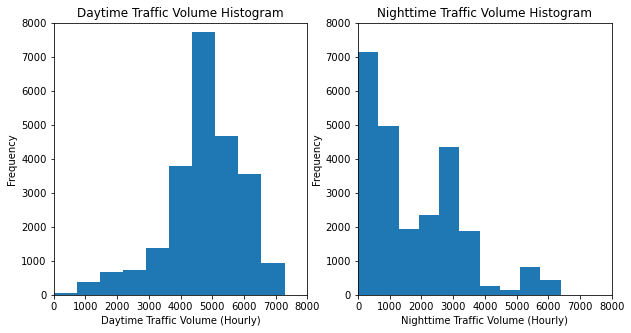

In [24]:
# Creating the grid chart

plt.figure(figsize=(10, 5))

# daytime histogram
plt.subplot(1, 2, 1)
plt.hist(traffic_day['traffic_volume'])
plt.title('Daytime Traffic Volume Histogram')
plt.xlabel('Daytime Traffic Volume (Hourly)')
plt.ylabel('Frequency')
plt.ylim([0,8000])
plt.xlim([0,8000])

# nighttime histogram
plt.subplot(1, 2, 2)
plt.hist(traffic_night['traffic_volume'])
plt.title('Nighttime Traffic Volume Histogram')
plt.xlabel('Nighttime Traffic Volume (Hourly)')
plt.ylabel('Frequency')
plt.ylim([0,8000])
plt.xlim([0,8000])

plt.show()

From the above, we see that the hourly traffic volume is typically high during the daytime, with the majority of the daytime traffic volume being between 4000 - 6000 cars/hour. On the other hand, the majority of the nighttime traffic volume is between 0 to 1500 cars/hour and 2500 - 3000 cars/hour, i.e. traffic is lighter at night.

The daytime traffic histogram is left-skewed, which indicates that the mean traffic volume is larger than the median. The nighttime traffic volume is bimodal, i.e. there are two peaks which could indicate that there are factors aside from the fact that it is nighttime that affect the traffic volume at night (i.e. different conditions led to the seperate peaks).

Although the mean/median/mode of the nighttime traffic is lower than daytime traffic, we can still analyse the nighttime traffic to get details about LOW traffic indicators and whether they are the exact opposite counterparts of the high traffic indicators that we find.

We will now consider the relationships between traffic volume and 1) Month, 2) Day of the week, and 3) Time of Day seperately for daytime and nighttime traffic. We will group the dataset according to these, and then calculate the traffic volume average of each group.

In [35]:
# daytime traffic data

traffic_day['month'] = traffic_day['date_time'].dt.month
print(traffic_day.loc[:,['month','date_time']])


       month           date_time
0         10 2012-10-02 09:00:00
1         10 2012-10-02 10:00:00
2         10 2012-10-02 11:00:00
3         10 2012-10-02 12:00:00
4         10 2012-10-02 13:00:00
...      ...                 ...
48194      9 2018-09-30 15:00:00
48195      9 2018-09-30 15:00:00
48196      9 2018-09-30 16:00:00
48197      9 2018-09-30 17:00:00
48198      9 2018-09-30 18:00:00

[23877 rows x 2 columns]


<ipython-input-35-2f04fc38feaa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_day['month'] = traffic_day['date_time'].dt.month


In [41]:
# daytime traffic's monthly average traffic volume

daytime_monthly_average = traffic_day.groupby('month').mean()
print(daytime_monthly_average['traffic_volume'])
print(daytime_monthly_average)

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64
             temp   rain_1h   snow_1h  clouds_all  traffic_volume
month                                                            
1      265.483409  0.015080  0.000631   58.554108     4495.613727
2      266.663789  0.004019  0.000000   51.550459     4711.198394
3      273.619940  0.015839  0.000000   56.827811     4889.409560
4      279.661071  0.105343  0.000000   59.221525     4906.894305
5      289.282668  0.130863  0.000000   56.548825     4911.121609
6      294.576068  0.271121  0.000000   48.612374     4898.019566
7      296.785052  4.412258  0.000000   42.176619     4595.035744
8      295.119191  0.228113  0.000000   42.556892     4928.302035
9      292.520287  0.289807  0.000000   45.184112     4870.783145
10     284.0810

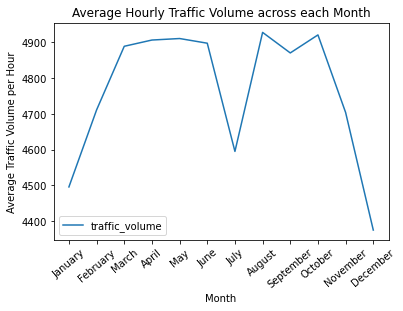

In [45]:
# Plotting a line plot of the monthly average traffic volume

daytime_monthly_average.plot.line(y='traffic_volume')
plt.xlabel('Month')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['January', 
                                                    'February',
                                                    'March',
                                                    'April',
                                                    'May',
                                                    'June',
                                                    'July',
                                                    'August',
                                                    'September',
                                                    'October',
                                                    'November',
                                                    'December'], rotation=40)
plt.ylabel('Average Traffic Volume per Hour')
plt.title('Average Hourly Traffic Volume across each Month')
plt.show()

From the above line plot, we see that traffic is at is heaviest from February to June, and from August to October. There is a sharp dip in traffic volume in the month of July and the months of November to February.


In [46]:
# Daytime traffic's average daily traffic for each day of the week


traffic_day['dayofweek'] = traffic_day['date_time'].dt.dayofweek
daytime_daily_average = traffic_day.groupby('dayofweek').mean()
print(daytime_daily_average['traffic_volume'])
print(daytime_daily_average)


<ipython-input-46-67ab20525155>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_day['dayofweek'] = traffic_day['date_time'].dt.dayofweek


dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64
                 temp   rain_1h   snow_1h  clouds_all  traffic_volume  \
dayofweek                                                               
0          282.262755  2.923823  0.000017   57.508053     4893.551286   
1          282.301770  0.129172  0.000194   52.333234     5189.004782   
2          282.198316  0.068099  0.001091   53.662119     5284.454282   
3          282.279115  0.172436  0.000148   53.993191     5311.303730   
4          282.181216  0.092828  0.000225   51.412200     5291.600829   
5          282.300646  0.107596  0.000094   50.446376     3927.249558   
6          282.280340  0.133170  0.000000   52.288699     3436.541789   

              month  
dayofweek            
0          6.401243  
1          6.458757  
2          6.619158  
3          6.501184  
4          6.575067  
5          6.498821  


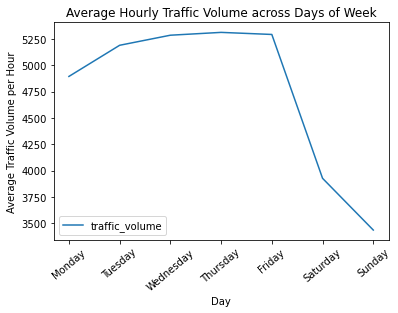

In [48]:
# Plotting a line graph of traffic volume against day of the week.

daytime_daily_average.plot.line(y='traffic_volume')
plt.xlabel('Day')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=40)
plt.ylabel('Average Traffic Volume per Hour')
plt.title('Average Hourly Traffic Volume across Days of Week')
plt.show()

From the above, we see that traffic is much heavier on weekdays/business days then on the weekends. 
On weekdays, the traffic is lightest on Monday, and increases until it is relatively constant across Wednesday to Friday. It then experiences a sharp drop from Friday to Saturday, before dropping even more until Sunday.

We now analyse the relationship between traffic volume and the time of day.
The weekends, however, will drag down the average values, so we're going to look at the averages separately. Hence, we'll start by splitting the data based on the day type: business day or weekend.

In [52]:
# splitting the daytime dataset into buisness day and weekend sets

traffic_day['hour'] = traffic_day['date_time'].dt.hour # create an 'hour' column

business_daytime = traffic_day.copy()[traffic_day['dayofweek']<=4] # where 4 == Friday
weekend_daytime = traffic_day.copy()[traffic_day['dayofweek']>4] # 5 = Saturday, 6 = Sunday

business_hour_average = business_daytime.groupby('hour').mean()
weekend_hour_average = weekend_daytime.groupby('hour').mean()

print(business_hour_average['traffic_volume'])
print(weekend_hour_average['traffic_volume'])


<ipython-input-52-5a9cac373553>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_day['hour'] = traffic_day['date_time'].dt.hour # create an 'hour' column


hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


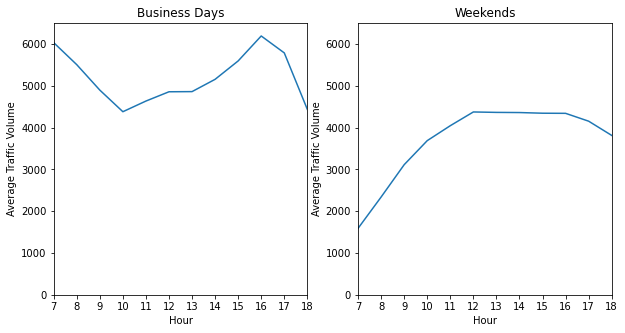

In [62]:
# Plotting 2 line plots on a grid chart to compare the business days and weekends hourly average.

plt.figure(figsize=(10,5))

# business days plot

plt.subplot(1, 2, 1)
plt.plot(business_hour_average.index, business_hour_average['traffic_volume'])
plt.xticks([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
plt.xlabel('Hour')
plt.xlim([7,18])
plt.ylabel('Average Traffic Volume')
plt.ylim([0, 6500])
plt.title('Business Days')

# weekends plot

plt.subplot(1, 2, 2)
plt.plot(weekend_hour_average.index, weekend_hour_average['traffic_volume'])
plt.xticks([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
plt.xlabel('Hour')
plt.xlim([7,18])
plt.ylabel('Average Traffic Volume')
plt.ylim([0, 6500])
plt.title('Weekends')

plt.show()

From the above, it is clear that the traffic volume across all hours is higher for business days compared to weekends. 

For business days, the peak traffic volumes during daytime are at 0700 and 1630 Hrs, with periods of relatively lower traffic from 1000 to 1500 and after 1700 Hrs. The two peaks seem to correspond with the typical work-start and work-end times respectively.

For weekends, traffic volume is low in the early morning, and rises constantly from 0700 to 1100. A plateau occurs from 1100 to 1600 Hrs, before starting to decrease after that. The relatively light traffic on weekend mornings could be the result of people waking up later due to there not being work, while the plateau could be indicative of people spending most of the afternoon out and about travelling.



In summary, we have found that traffic volume is higher for much largeer parts of the daytime compared to the nighttime, and that such daytime traffic is significantly heavier on business days than weekends.

Traffic is heavier across the warm months from March to October, and lighter in the colder months from November to February.

For weekdays, the peak rush hours are at 0700 Hrs in the morning and 1630 Hrs in the evening, though the volume is on average much higher across even the non-rush hours when compared to even the peak of the weekends. The weekends have slow mornings, and peak/plateau across the afternoon from 1100 to 1600 Hrs.

Having checked for possible time indicators of traffic volume, we now check for possible weather indicators (e.g. rain_1h, clouds_all etc.) We begin by checking the correlation values between the numerical weather indicators and traffic_volume. Note that from this point on, we are still only considering daytime traffic.

In [67]:
# dataframe of all paired correlation values for daytime traffic

traffic_day_corr = traffic_day.corr()
print(traffic_day_corr)

                    temp   rain_1h   snow_1h  clouds_all  traffic_volume  \
temp            1.000000  0.010815 -0.019286   -0.135519        0.128317   
rain_1h         0.010815  1.000000 -0.000091    0.004993        0.003697   
snow_1h        -0.019286 -0.000091  1.000000    0.027721        0.001265   
clouds_all     -0.135519  0.004993  0.027721    1.000000       -0.032932   
traffic_volume  0.128317  0.003697  0.001265   -0.032932        1.000000   
month           0.222072  0.001176  0.026768    0.000595       -0.022337   
dayofweek       0.000188 -0.009683 -0.008814   -0.041980       -0.416453   
hour            0.162691  0.008279  0.003923    0.023685        0.172704   

                   month  dayofweek      hour  
temp            0.222072   0.000188  0.162691  
rain_1h         0.001176  -0.009683  0.008279  
snow_1h         0.026768  -0.008814  0.003923  
clouds_all      0.000595  -0.041980  0.023685  
traffic_volume -0.022337  -0.416453  0.172704  
month           1.000000   

In [71]:
# correlations of all numerical weather values with 'traffic_volume' excluding itself.

print(traffic_day_corr['traffic_volume'][traffic_day_corr['traffic_volume']!=1])

temp          0.128317
rain_1h       0.003697
snow_1h       0.001265
clouds_all   -0.032932
month        -0.022337
dayofweek    -0.416453
hour          0.172704
Name: traffic_volume, dtype: float64


From the above series, we see that the numerical weather value with the strongest correlation to traffic volume is the temperature (R=0.128317). However, this is still a very weak correlation (~0.1), and hence it (and all other weather values) cannot be considered as good weather indicators of traffic volume.

As such, we next check the categorical (object) weather-related columns: 'weather_main' and 'weather_description'.

|Header|Description|
|------|-----------|
|weather_main|Categorical Short textual description of the current weather|
|weather_description|Categorical Longer textual description of the current weather|

In [72]:
print(traffic_day['weather_main'].unique())
print(traffic_day['weather_description'].unique())

['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Smoke' 'Squall']
['scattered clouds' 'broken clouds' 'overcast clouds' 'sky is clear'
 'few clouds' 'light rain' 'light intensity drizzle' 'mist' 'haze'
 'proximity shower rain' 'moderate rain' 'drizzle' 'heavy intensity rain'
 'fog' 'proximity thunderstorm' 'heavy snow' 'snow' 'freezing rain'
 'shower snow' 'light rain and snow' 'light intensity shower rain'
 'thunderstorm with heavy rain' 'thunderstorm with rain'
 'thunderstorm with light rain' 'proximity thunderstorm with rain'
 'heavy intensity drizzle' 'Sky is Clear' 'very heavy rain'
 'proximity thunderstorm with drizzle' 'light snow'
 'thunderstorm with drizzle' 'thunderstorm' 'smoke' 'SQUALLS'
 'light shower snow' 'sleet' 'thunderstorm with light drizzle'
 'shower drizzle']


In [95]:
# average daytime traffic volume grouped by weather_main

by_weather_main = traffic_day.groupby('weather_main').mean()
print(by_weather_main['traffic_volume'].describe())
print('\n')

# average daytime traffic volume grouped by weather_description

by_weather_desc = traffic_day.groupby('weather_description').mean()
print(by_weather_desc['traffic_volume'].describe())


count      11.000000
mean     4611.190225
std       212.710591
min      4211.000000
25%      4480.452258
50%      4623.976475
75%      4796.992361
max      4865.415996
Name: traffic_volume, dtype: float64


count      38.000000
mean     4641.725800
std       505.182235
min      2297.000000
25%      4506.945833
50%      4704.532384
75%      4860.756426
max      5664.000000
Name: traffic_volume, dtype: float64


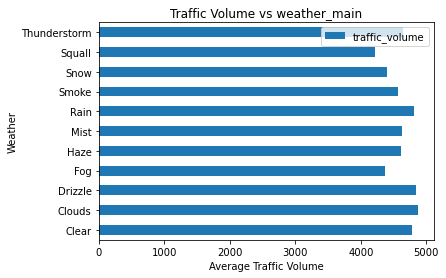

In [79]:
# horizontal bar plot of traffic volume vs weather_main

by_weather_main.plot.barh(y='traffic_volume')
plt.ylabel('Weather')
plt.xlabel('Average Traffic Volume')
plt.title('Traffic Volume vs weather_main')
plt.show()


From the plot, we see that no weather_main values lead to a traffic volume above 5000, and that almost of all the weather_main conditions give average traffic volumes that are close to the mean of the averages. All the average traffic volumes lie within 2 standard deviations of the mean average traffic volume, and hence there are no clear outliers/exceptions indicating exceptional traffic volume.
As such, it is not useful as an indicator of heavy traffic.

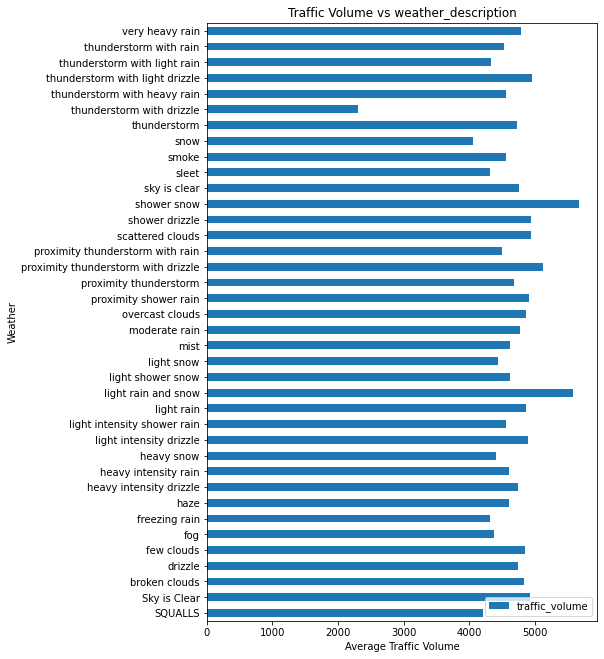

In [91]:
# horizontal bar plot of traffic volume vs weather_description

by_weather_desc.plot.barh(y='traffic_volume', figsize=(7,11))
plt.ylabel('Weather')
plt.xlabel('Average Traffic Volume')
plt.title('Traffic Volume vs weather_description')
plt.show()


From the above plot, we see that the 'shower drizzle' and 'light rain and snow' weather descriptions lead to traffic volumes that are greater than all the other weather descriptions at around 5664.

## Conclusions

In general, we found that for westward bound vehicles, daytime traffic was significantly much more likely to have heavy traffic than nighttime traffic.

From our above analysis, we have determined that the following are good time indicators of heavy traffic for DAYTIME traffic only:
<ul>
    <li>Day of the week (Business Days of Monday to Friday)</li>
    <li>Hour of the day (0700Hrs and 1630Hrs)</li>
    <li>Month of the Year (Warm Months from March to October)</li>
</ul>

and that the following are good weather indicators:
<ul>
    <li>Weather Description ('shower drizzle' and 'light rain and snow')</li>
</ul>